# genetic k-means

In [51]:
# generating sample dataset
from sklearn.datasets import make_blobs

num_clusters = 4
num_features = 3
num_samples = 400
X, y = make_blobs(n_samples=num_samples,
                  centers=num_clusters,
                  n_features=num_features,
                  random_state=42)

In [ ]:
# define functions for gka

import numpy as np


def initialize_centroids(data: np.ndarray, k: int) -> np.ndarray:
    n_samples = data.shape[0]
    if k > n_samples:
        raise ValueError("The number of clusters (k) cannot be greater than the total number of samples.")
    
    random_indices = np.random.choice(n_samples, size=k, replace=False)
    centroids = data[random_indices]
    return centroids


def assign_clusters(data: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    data_expanded = data[:, np.newaxis, :] 
    centroids_expanded = centroids[np.newaxis, :, :]
    
    distances_sq = np.sum((data_expanded - centroids_expanded)**2, axis=2)
    
    cluster_indices = np.argmin(distances_sq, axis=1)
    
    return cluster_indices


def get_one_hot_from(data: np.ndarray, k: int, cluster_indices: np.ndarray) -> np.ndarray:
    n_samples = data.shape[0]

    w = np.zeros((n_samples, k), dtype=int)
    w[np.arange(n_samples), cluster_indices] = 1
    
    return w



def calculate_inertia(data: np.ndarray, centroids: np.ndarray, cluster_indices: np.ndarray) -> float:
    assigned_centroids = centroids[cluster_indices]
    inertia = np.sum((data - assigned_centroids)**2)
    return float(inertia)


def update_centroids(data: np.ndarray, w: np.ndarray, k: int, old_centroids: np.ndarray) -> np.ndarray:
    new_centroids = np.zeros_like(old_centroids)
    
    num_points_in_cluster = np.sum(w, axis=0)
    
    sum_cluster_points_matrix = np.dot(w.T, data)
    
    for j in range(k):
        if num_points_in_cluster[j] > 0:
            new_centroids[j] = sum_cluster_points_matrix[j] / num_points_in_cluster[j]
        else:
            new_centroids[j] = old_centroids[j]
            
    return new_centroids


def selection_tournament(individuals, fitnesses, population_size, group_size = 2):
    selected = np.zeros_like(individuals)
    selected_idx = []
    for i in range(len(individuals)):
        candidates = np.random.choice(population_size, size=group_size, replace=False)
        idx = candidates[np.argmax(fitnesses[candidates])]
        selected[i] = individuals[idx]
        selected_idx.append(idx)
    return selected, np.array(selected_idx)


def mutation_by_dist(population, centroids, num_samples, num_clusters, mutation_rate = 0.05):
    mutated_population = population.copy()

    for labels, c in zip(mutated_population, centroids):
        dists = np.linalg.norm(X - c[labels], axis=1)
        total_dist = np.sum(dists)
        mutation_probs = dists / total_dist
        num_mutations = int(np.ceil(mutation_rate * num_samples))
        mutation_indices = np.random.choice(num_samples, size=num_mutations, replace=False, p=mutation_probs)
        for idx in mutation_indices:
            current_label = labels[idx]
            other_labels = [l for l in range(num_clusters) if l != current_label]
            labels[idx] = np.random.choice(other_labels)

        
        while len(np.unique(labels)) < num_clusters:
            idx = np.random.choice(mutation_indices)
            current_label = labels[idx]
            other_labels = [l for l in range(num_clusters) if l != current_label]
            labels[idx] = np.random.choice(other_labels)

    return mutated_population


def one_step_k_means(population, data, default_centroids):
    new_generation = []
    for indi, old in zip(population, default_centroids):
        w = get_one_hot_from(data, num_clusters, indi)
        new_centroids = update_centroids(data, w, num_clusters, old)
        new_indi = assign_clusters(data, new_centroids)
        new_generation.append(new_indi)
    return np.array(new_generation)


In [52]:
max_generation = 10

# initialize population

population_size = 10
population = np.random.randint(0, num_clusters, size=[population_size, num_samples])
default_centroids = np.random.randn(*[population_size, num_clusters, num_features])

history = []

for gen in range(max_generation):
    
    # compute label matrix
    ws = [get_one_hot_from(X, num_clusters, label) for label in population]

    # compute centroids
    centroids = np.array([
        update_centroids(X, w, num_clusters, old) for w, old in zip(ws, default_centroids)
    ])

    # calculate fitness (-inertia)
    fitnesses = np.array([
        -calculate_inertia(X, means, idx) for means, idx in zip(centroids, population)
    ])

    # selection
    selected, selected_idx = selection_tournament(population,
                                                  fitnesses,
                                                  population_size)
    
    # mutation
    mutated = mutation_by_dist(selected, centroids[selected_idx], num_samples, num_clusters)

    # one-step k-means
    new_population = one_step_k_means(mutated, X)

    population = new_population

    history.append(fitnesses)

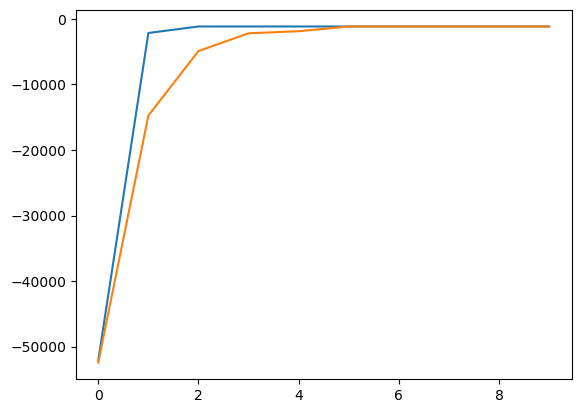

In [53]:
import matplotlib.pyplot as plt

maxs = [np.max(fits) for fits in history]
means = [np.mean(fits) for fits in history]

plt.plot(maxs)
plt.plot(means)
plt.show()

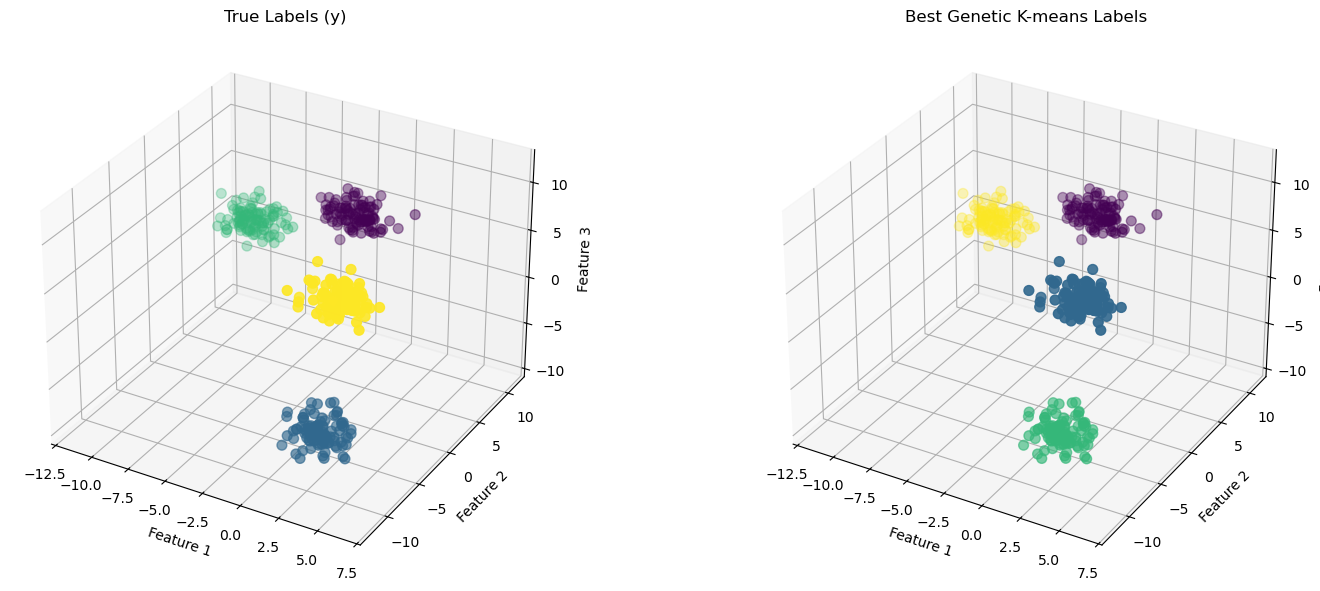

In [54]:
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
scatter1 = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', s=50)
ax1.set_title("True Labels (y)")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_zlabel("Feature 3")

best_labels = population[np.argmax(history[-1])]
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter2 = ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=best_labels, cmap='viridis', s=50)
ax2.set_title("Best Genetic K-means Labels")
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")
ax2.set_zlabel("Feature 3")

plt.tight_layout()
plt.show()

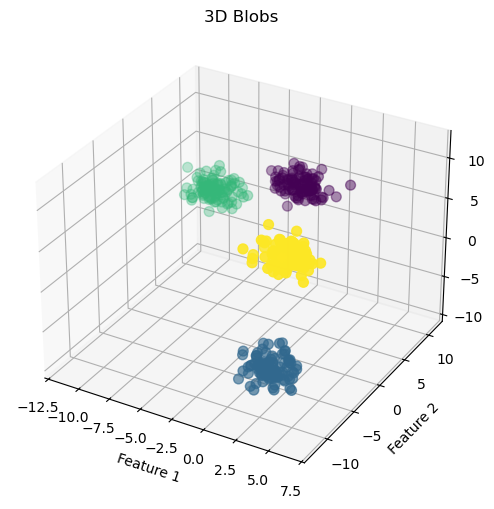

In [47]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', s=50)

# Add labels and title
ax.set_title("3D Blobs")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.show()

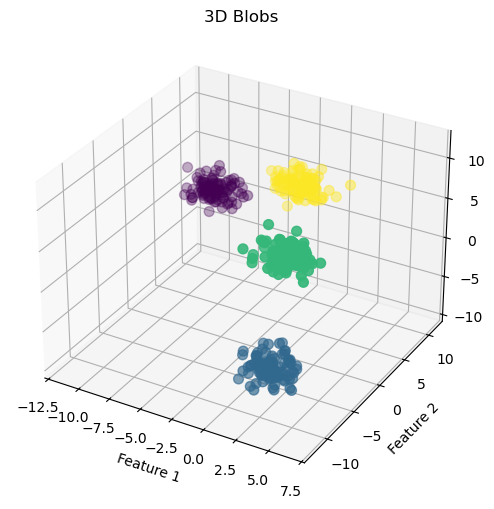

In [48]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=population[np.argmax(history[-1])], cmap='viridis', s=50)

# Add labels and title
ax.set_title("3D Blobs")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.show()

In [ ]:
# initialize population

population_size = 10
population = np.random.randint(0, num_clusters, size=[population_size, num_samples])


print(population[:, :10])

[[0 0 2 2 3 0 1 2 3 0]
 [2 0 1 2 2 3 1 1 2 3]
 [1 0 0 2 2 2 0 1 0 3]
 [0 3 1 2 2 3 1 2 0 3]
 [0 0 0 0 1 2 2 3 0 3]
 [3 1 2 1 0 2 3 3 3 2]
 [0 2 3 1 2 1 1 1 2 2]
 [3 2 0 1 1 2 2 3 0 2]
 [0 0 2 3 1 1 3 1 1 0]
 [0 2 3 1 1 2 0 3 2 2]]


In [4]:
# set initial centroids
default_centroids = np.random.randn(*[population_size, num_clusters, num_features])
print(default_centroids.shape)

(10, 4, 3)


In [5]:
# compute label matrix
ws = [get_one_hot_from(X, num_clusters, label) for label in population]

In [23]:
# compute centroids
centroids = np.array([
    update_centroids(X, w, num_clusters, old) for w, old in zip(ws, default_centroids)
])

In [35]:
newone=assign_clusters(X, centroids[0])

In [38]:
# calculate fitness (inertia)
fitnesses = np.array([
    -calculate_inertia(X, means, idx) for means, idx in zip(centroids, population)
])

In [39]:
# select tournament
def selection_tournament(individuals, fitnesses, population_size, group_size = 2):
    selected = np.zeros_like(individuals)
    selected_idx = []
    for i in range(len(individuals)):
        candidates = np.random.choice(population_size, size=group_size, replace=False)
        idx = candidates[np.argmax(fitnesses[candidates])]
        selected[i] = individuals[idx]
        selected_idx.append(idx)
    return selected, np.array(selected_idx)

selected, selected_idx = selection_tournament(population,
                                              fitnesses,
                                              population_size)

In [40]:
# mutation
def mutation_by_dist(population, centroids, num_samples, num_clusters, mutation_rate = 0.05):
    mutated_population = population.copy()

    for labels, c in zip(mutated_population, centroids):
        dists = np.linalg.norm(X - c[labels], axis=1)
        total_dist = np.sum(dists)
        mutation_probs = dists / total_dist
        num_mutations = int(np.ceil(mutation_rate * num_samples))
        mutation_indices = np.random.choice(num_samples, size=num_mutations, replace=False, p=mutation_probs)
        for idx in mutation_indices:
            current_label = labels[idx]
            other_labels = [l for l in range(num_clusters) if l != current_label]
            labels[idx] = np.random.choice(other_labels)

        
        while len(np.unique(labels)) < num_clusters:
            idx = np.random.choice(mutation_indices)
            current_label = labels[idx]
            other_labels = [l for l in range(num_clusters) if l != current_label]
            labels[idx] = np.random.choice(other_labels)

    return mutated_population

mutated = mutation_by_dist(selected, centroids[selected_idx], num_samples, num_clusters)

In [41]:
def one_step_k_means(population, data):
    new_generation = []
    for indi, old in zip(population, default_centroids):
        w = get_one_hot_from(data, num_clusters, indi)
        new_centroids = update_centroids(data, w, num_clusters, old)
        new_indi = assign_clusters(data, new_centroids)
        new_generation.append(new_indi)
    return np.array(new_generation)

new_population = one_step_k_means(population, X)

In [42]:
new_population.shape

(10, 400)

In [19]:
tmp = np.random.randn(10, 3)
print(tmp)
print(selected_idx)
print(tmp[selected_idx])

[[-0.9223 -0.6739 -0.1214]
 [-1.085   0.9654 -0.4843]
 [-1.1159 -1.2746  0.9902]
 [-0.7725 -0.5976 -1.4101]
 [ 2.4625 -0.3491  0.5163]
 [-0.8609  0.6451  1.7027]
 [ 0.1992 -1.1782 -0.3545]
 [ 1.2423 -0.3613 -0.6147]
 [-0.703   2.056   0.2143]
 [ 0.0954 -0.777  -0.128 ]]
[3 1 1 4 5 7 9 7 7 6]
[[-0.7725 -0.5976 -1.4101]
 [-1.085   0.9654 -0.4843]
 [-1.085   0.9654 -0.4843]
 [ 2.4625 -0.3491  0.5163]
 [-0.8609  0.6451  1.7027]
 [ 1.2423 -0.3613 -0.6147]
 [ 0.0954 -0.777  -0.128 ]
 [ 1.2423 -0.3613 -0.6147]
 [ 1.2423 -0.3613 -0.6147]
 [ 0.1992 -1.1782 -0.3545]]


In [12]:
d=np.linalg.norm(X - centroids[0][selected[0]], axis=1)
td = np.sum(d)
mp = d/td
np.sum(mp)

np.float64(1.0)

In [ ]:
# mutation


In [ ]:
candidates = np.random.choice(population_size, size=2, replace=False)
print(candidates)
print(fitnesses[candidates])
print(candidates[np.argmax(fitnesses[candidates])])

[2 1]
[85556.023  84974.5968]
2


In [ ]:
tmp = np.zeros([5, 10])


array([1, 4])

In [ ]:




## -------------------------------------------------------------------------- ##
## K-평균 알고리즘 전체 구현 (위 함수들 사용)
## -------------------------------------------------------------------------- ##



def k_means_algorithm(data: np.ndarray, k: int, max_iterations: int = 100, tol: float = 1e-4, random_state: int = None) -> tuple[np.ndarray, np.ndarray, float]:
    """
    K-평균 클러스터링 알고리즘을 수행합니다.

    Args:
        data (np.ndarray): 입력 데이터 (n_samples, n_features).
        k (int): 클러스터의 개수.
        max_iterations (int): 최대 반복 횟수.
        tol (float): 중심점 변화량이 이 값보다 작으면 수렴으로 간주하는 허용 오차.
        random_state (int, optional): 초기 중심점 선택의 재현성을 위한 난수 시드.

    Returns:
        tuple: (최종 중심점, 최종 할당 행렬 w, 최종 inertia 값)
    """
    if random_state is not None:
        np.random.seed(random_state)

    # 1. 초기 중심점 생성
    current_centroids = initialize_centroids(data, k)
    
    for i in range(max_iterations):
        # 2. 클러스터 할당 (E-step과 유사)
        w = assign_clusters(data, current_centroids)
        
        # 3. 중심점 업데이트 (M-step과 유사)
        new_centroids = _update_centroids(data, w, k, current_centroids)
        
        # 4. 수렴 조건 확인: 중심점의 변화가 매우 작으면 종료
        if np.allclose(current_centroids, new_centroids, atol=tol, rtol=0): # 절대 허용 오차 사용
            # print(f"정보: {i+1} 번째 반복에서 중심점 안정화로 수렴했습니다.") # 필요시 주석 해제
            current_centroids = new_centroids # 안정화된 중심점으로 최종 업데이트
            break 
            
        current_centroids = new_centroids
        
        # if i == max_iterations - 1: # 필요시 주석 해제
            # print(f"정보: 최대 반복 횟수 {max_iterations}에 도달했습니다.")
            
    # 최종 중심점에 대한 할당 행렬 w와 inertia 계산
    final_w = assign_clusters(data, current_centroids)
    final_inertia = calculate_inertia(data, current_centroids, final_w)
            
    return current_centroids, final_w, final_inertia

## -------------------------------------------------------------------------- ##
## 샘플 데이터셋에 대한 K-평균 알고리즘 시연
## -------------------------------------------------------------------------- ##

if __name__ == '__main__':
    # sklearn.datasets.make_blobs는 NumPy만 사용하는 제약조건 외 부분(데모용 데이터 생성)
    try:
        from sklearn.datasets import make_blobs
        SAMPLE_DATA_AVAILABLE = True
    except ImportError:
        SAMPLE_DATA_AVAILABLE = False
        print("sklearn 라이브러리를 찾을 수 없어 make_blobs를 사용한 데모를 실행할 수 없습니다.")
        print("K-평균 함수들은 NumPy만으로 구현되었으므로 직접 데이터를 준비하여 테스트할 수 있습니다.")

    if SAMPLE_DATA_AVAILABLE:
        # 샘플 데이터 생성
        n_samples = 300
        n_features = 2
        n_clusters = 4 # K-평균 알고리즘에 사용할 k 값
        
        # 실제론 make_blobs의 centers 파라미터로 클러스터 수를 정하지만, 여기선 k와 일치시킴
        X, y_true = make_blobs(n_samples=n_samples, 
                               centers=n_clusters, 
                               n_features=n_features, 
                               cluster_std=0.8, # 클러스터 내 표준편차
                               random_state=42) # 재현성을 위한 난수 시드

        print(f"샘플 데이터 생성 완료: {X.shape[0]}개의 샘플, {X.shape[1]}개의 특성")
        print(f"K-평균 알고리즘 실행 (k={n_clusters})")
        
        # K-평균 알고리즘 실행
        # random_state를 설정하여 실행할 때마다 동일한 초기 중심점으로 시작 (결과 재현)
        final_centroids, final_w, final_inertia = k_means_algorithm(X, k=n_clusters, random_state=0)
        
        print("\nK-평균 알고리즘 실행 완료!")
        print("------------------------------------")
        
        print(f"최종 중심점 (Final Centroids):\n{final_centroids}")
        print("------------------------------------")
        
        # final_w는 (n_samples, k) 형태의 큰 행렬이므로, 일부 정보만 출력
        print(f"최종 할당 행렬 w의 형태: {final_w.shape}")
        # 예시: 첫 5개 데이터 포인트의 클러스터 할당 인덱스
        # final_cluster_assignments = np.argmax(final_w, axis=1)
        # print(f"첫 5개 데이터 포인트의 클러스터 할당 인덱스: {final_cluster_assignments[:5]}")
        # print(" (참고: 0은 첫 번째 클러스터, 1은 두 번째 클러스터 등을 의미합니다.)")
        print("------------------------------------")
        
        print(f"최종 Inertia (Total Within-Cluster Sum of Squares): {final_inertia:.4f}")
        print("------------------------------------")

        # (선택 사항) 실제 레이블과 비교 (평가 목적, K-평균은 비지도 학습)
        # from sklearn.metrics import adjusted_rand_score
        # predicted_labels = np.argmax(final_w, axis=1)
        # ari_score = adjusted_rand_score(y_true, predicted_labels)
        # print(f"Adjusted Rand Index (vs true labels): {ari_score:.4f} (참고용)")

    # sklearn 없는 환경을 위한 간단한 테스트 데이터
    if not SAMPLE_DATA_AVAILABLE:
        print("\nsklearn.make_blobs를 사용할 수 없으므로, 간단한 자체 데이터로 테스트합니다.")
        # 간단한 2D 데이터 생성
        data_group1 = np.random.rand(50, 2) + np.array([0, 0])
        data_group2 = np.random.rand(50, 2) + np.array([3, 3])
        data_group3 = np.random.rand(50, 2) + np.array([0, 3])
        simple_data = np.vstack((data_group1, data_group2, data_group3))
        np.random.shuffle(simple_data) # 데이터 섞기
        
        k_simple = 3
        print(f"간단 데이터 생성 완료: {simple_data.shape[0]}개의 샘플, {simple_data.shape[1]}개의 특성")
        print(f"K-평균 알고리즘 실행 (k={k_simple})")

        final_centroids_simple, final_w_simple, final_inertia_simple = k_means_algorithm(simple_data, k=k_simple, random_state=1)

        print("\n간단 데이터 K-평균 알고리즘 실행 완료!")
        print("------------------------------------")
        print(f"최종 중심점 (Final Centroids):\n{final_centroids_simple}")
        print("------------------------------------")
        print(f"최종 Inertia: {final_inertia_simple:.4f}")
        print("------------------------------------")